Nolearn Tutorial (farm-ads)
====


# Farm-ads
[https://archive.ics.uci.edu/ml/datasets/Farm+Ads](https://archive.ics.uci.edu/ml/datasets/Farm+Ads)

* Farm-ads는 동물농장과 관련된 사이트에 게제된 text광고 데이터 셋이다. 데이터셋에 포함된 바이너리 레이블은 컨텐츠 소유자가 허용한 광고 여부이다. 소유자가 허용한 광고는 레이블 1이고, 허용하지 않은 레이블은 -1이다.

## 데이터 로드
* 다음은 Farm-ads 데이터를 load하는 함수이다. 데이터는 [다음 페이지](https://archive.ics.uci.edu/ml/datasets/Farm+Ads)에서 얻을 수 있다.

In [1]:
import numpy as np
def load_farm_ads_vect(path, vector_size=54878):
    X = []
    y = []
    with open(path, 'rb') as f:
        for line in f:
            yi, xi = line.split(' ', 1)
            y.append(1 if int(yi) == 1 else 0)
            
            word_vec = np.zeros(vector_size)
            for item in xi.split(' '):
                index, value = item.split(':')
                if int(index) < vector_size:
                    word_vec[int(index)] = float(value)
            X.append(word_vec)

    # Theano works with fp32 precision
    X = np.array(X).astype(np.float32)
    y = np.array(y).astype(np.int32)

    # For convolutional layers, the default shape of data is bc01,
    # i.e. batch size x color channels x image dimension 1 x image dimension 2.
    # Therefore, we reshape the X data to -1, 1, 28, 28.
    X = X.reshape(
        -1,  # number of samples, -1 makes it so that this number is determined automatically
        vector_size
    )
    return X, y

def load_farm_ads_words(path):
    words = []
    y = []
    with open(path, 'rb') as f:
        for line in f:
            yi, xi = line.split(' ', 1)
            y.append(yi)
            words.append(xi.strip().split(' '))

    y = np.array(y).astype(np.int32)
    return words, y

In [2]:
import os
path = os.path.join(os.path.expanduser('~'), 'datas/farm-ads/')
X, y = load_farm_ads_vect(path+'farm-ads-vect', 15000)
words, _ = load_farm_ads_words(path+'farm-ads')

In [3]:
print '[Expected] words...'
for i in range(5):
    print '[Rejected]' if y[i]==0 else '[Accepted]',
    print ' '.join([(word[3:] if 'ad-' in word else word) for word in words[i]][:6])

[Expected] words...
[Accepted] jerry bruckheimer chase premier sept th
[Rejected] rheumatoid arthritis expert tip info article
[Rejected] rheumatologist anju varghese yonker ny pomona
[Rejected] siemen water remediation water scarce resource
[Rejected] symptom muscle weakness genetic disease symptom


## NeuralNet
* Network & parameter 셋업

In [4]:
from lasagne.layers import *
from lasagne.nonlinearities import *
layers = [
    (InputLayer, {'shape': X.shape}),
    (DenseLayer, {'num_units': 256, 'nonlinearity': tanh}),
    (DenseLayer, {'num_units': 2, 'nonlinearity': softmax}),
]

In [5]:
from nolearn.lasagne import NeuralNet
from nolearn.lasagne import TrainSplit
from lasagne.objectives import *
from lasagne.updates import *

net = NeuralNet(
    layers=layers,
    
    train_split=TrainSplit(eval_size=0.1),
    max_epochs = 10,
    
    update=sgd,
    update_learning_rate=0.05,
    
    verbose=1,
)

### training

In [6]:
_ = net.fit(X, y)

# Neural Network with 3840770 learnable parameters

## Layer information

  #  name      size
---  ------  ------
  0  input0   15000
  1  dense1     256
  2  dense2       2

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  -----
      1       0.46751       0.36443      1.28286      0.86643  1.26s
      2       0.34020       0.30693      1.10840      0.89989  1.51s
      3       0.28847       0.27955      1.03189      0.90184  1.27s
      4       0.25352       0.26298      0.96403      0.91551  1.24s
      5       0.22687       0.25183      0.90088      0.91576  1.22s
      6       0.20539       0.24387      0.84219      0.91381  1.26s
      7       0.18750       0.23799      0.78786      0.91576  1.25s
      8       0.17232       0.23357      0.73777      0.91576  1.26s
      9       0.15926       0.23023      0.69174      0.91381  1.26s
     10       0.14790       0.22767      0.64963      0.91772  1.24s

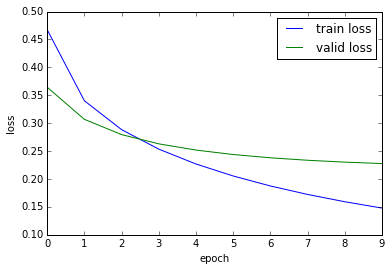

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
from nolearn.lasagne.visualize import plot_loss
plot_loss(net)

### evaluation

In [8]:
y_hat = net.predict(X)

In [9]:
from sklearn.metrics import classification_report
print classification_report(y, y_hat)

             precision    recall  f1-score   support

          0       0.96      0.94      0.95      1933
          1       0.95      0.97      0.96      2210

avg / total       0.96      0.96      0.96      4143



In [10]:
print '[Expected] [Predict ] words...'
for i in range(30):
    print '[Rejected]' if y[i]==0 else '[Accepted]',
    print '[Rejected]' if y_hat[i]==0 else '[Accepted]',
    print ' '.join([(word[3:] if 'ad-' in word else word) for word in words[i]][:6])

[Expected] [Predict ] words...
[Accepted] [Accepted] jerry bruckheimer chase premier sept th
[Rejected] [Rejected] rheumatoid arthritis expert tip info article
[Rejected] [Rejected] rheumatologist anju varghese yonker ny pomona
[Rejected] [Rejected] siemen water remediation water scarce resource
[Rejected] [Rejected] symptom muscle weakness genetic disease symptom
[Accepted] [Accepted] animal animal wild sa official tourism
[Rejected] [Rejected] dr enrico fazzini parkinson disease specialist
[Rejected] [Rejected] ulcerative colitis uc quiz ulcerative colitis
[Rejected] [Rejected] wellcentive registry web base preventive care
[Accepted] [Accepted] free raw food video feature mike
[Rejected] [Rejected] north shore lij cancer center provide
[Accepted] [Accepted] world finest alpaca breeder seller finest
[Accepted] [Accepted] vet online veterinarian online question answer
[Rejected] [Rejected] gum disease treatment dentist near treatment
[Accepted] [Accepted] rabbit guinea pig hutch deal s